## Outline

- [x] Build data set.
- [x] Build NN infrastructure:
   - [x] How to compute gradients
   - [x] Select architecture
   - [x] Tune hyperparameters
- [x] Train and test NN.
- [x] Run some dynamics on the new PES

### Build data set.
Our system is H$_2$CO$^+$, a charged, open shell molecular system. The idea is to start from chemically relevant structures such as some minima and transition states, such as those reported at [Moyano 2006](https://aip.scitation.org/doi/10.1063/1.2181571), as shown in Figure 1. I will for simplicity not include all of these structure, but only the most representative of the PES (the lowest energy configurations: ).

<img src="./Structs.png" width='700'>

The idea for now is to start from these structures and randomly sample other structures around these, so non-important regions of the PES are not explored in detriment of the important ones. (Though there are much better approximations to sampling, we'll be doing this for now, for simplicity).

As the inputs we'll be using the inverses of distances between ALL pairs of atoms, so as to fully describe the molecule's geometry and account for shorter distances representing stronger interactions.

We should as well account for the symmetry of the molecule, that is, the molecule is exactly the same upon exchange of two identical atoms (in this case the hydrogen atoms) and thus all its properties. This can be circumvented by exchanging identical atoms for each new geometry and saving this to the training set as well, which will lead to a larger but symmetrically consistent dataset.


### Note: I have quick access to some files and datasets (such as the Structs.xyz file which contains the geometries of these structures) because I recently started to do some work alongside G.E. Moyano, but this has (yet) nothing to do with neural networks so this work applies for the Machine Learning for Physicists course.

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import psi4

In [2]:
atoms = ['O','C','H1','H2']
#Now actually read the Structs file, compute distances and fill df

def loadCoords(file='Structs.xyz'):
    #Empty df for holding training examples
    df = pd.DataFrame({})
    
    with open(file,'r') as file:
        line = 'True'
        struct = pd.DataFrame({})
        h_index = 1  #Index of the H atom, so as to distinguish both atoms
        while line:
            line = file.readline()
            if not line: #If end of line, end loop
                break 

            if line[-5:].strip() == '.log':
                name = line[:-5]
                #Restart struct df
                struct = pd.DataFrame({})

            elif line[0]!= '\n': #If line not a name, then read structures
                line = line.split(' ')
                atom = line[0] #atom name

                #Distinguish between the two H atoms: rename as H1 and H2
                if atom == 'H':
                    atom = atom + str(h_index)
                    if h_index == 1: h_index += 1
                    else: h_index = 1

                #Read coordinates and append to struct df
                coords = pd.Series(line[1:],name=atom).astype(float)
                struct=struct.append(coords)

                if struct.shape[0] == 4:  #If reading atoms is done, do computations
                    struct = struct.loc[atoms] #Reorder atoms
                    df = df.append(pd.Series(struct.values.ravel(),name=name))
        return df

#DF columns are: (x,y,z) coords for O,C,H1,H2, in that order (Ox, Oy, Oz, Cx, ...)
df = loadCoords(file='Structs.xyz')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
m10,0.018902,0.0,0.007275,-0.227835,0.0,1.142721,0.230513,0.0,-0.966525,9.074669,0.0,-17.712857
m11,12.285352,0.0,-4.190886,12.574280,0.0,-3.136145,-0.039439,0.0,-0.055729,0.152842,0.0,0.657169
m12,0.000000,0.0,0.000000,0.000000,0.0,1.093536,0.201882,0.0,-3.174882,0.927414,0.0,-3.034873
m1,0.000000,0.0,1.217334,0.000000,0.0,0.000000,0.819430,0.0,-0.733547,0.869755,0.0,1.691461
m2,-0.022028,0.0,1.335390,0.063013,0.0,0.115731,1.009366,0.0,-0.441728,-0.937213,0.0,1.710607


Now that we have loaded the initial structures, let's pick the important ones, that is the ones that are connected to the lowest energy state (near regions) and are as well low energy states.
The following figure shows an energy (HF) map of these structures as named in the df.

<img src="./HFmap.png" width='700'>

From this figure, we select the following structures, as these are representative points of the PES around the lowest energy configuration:

M3 M1 M2 M4 TS1 TS2 M10 TS9 TS8 M9 TS3 TS4 M5 TS5 M6 

In [3]:
select = ['M3','M1','M2','M4','TS1','TS2','M10','TS9','TS8','M9','TS3','TS4','M5','TS5','M6']
select = list(map(str.lower,select))

df = df.loc[select]
df

,0,1,2,3,4,5,6,7,8,9,10,11
m3,0.000000,0.000000e+00,1.120014,0.000000,0.000000e+00,0.000000,-0.000003,0.000000e+00,-1.092344,-8.448711,0.000000e+00,4.106705
m1,0.000000,0.000000e+00,1.217334,0.000000,0.000000e+00,0.000000,0.819430,0.000000e+00,-0.733547,0.869755,0.000000e+00,1.691461
m2,-0.022028,0.000000e+00,1.335390,0.063013,0.000000e+00,0.115731,1.009366,0.000000e+00,-0.441728,-0.937213,0.000000e+00,1.710607
m4,-1.049884,0.000000e+00,-0.573050,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.110800,0.934271,0.000000e+00,-0.600844
ts1,0.011722,2.054430e-01,1.154709,-0.003745,8.313800e-02,-0.038738,0.867926,-1.327280e-01,-0.684711,0.036030,2.871930e-01,2.130090
ts2,0.187998,0.000000e+00,1.240488,0.156991,0.000000e+00,0.110274,1.381388,0.000000e+00,2.055910,0.463139,0.000000e+00,-0.938633
m10,0.018902,0.000000e+00,0.007275,-0.227835,0.000000e+00,1.142721,0.230513,0.000000e+00,-0.966525,9.074669,0.000000e+00,-17.712857
ts9,-0.028217,-1.145000e-07,-0.005133,-0.056415,8.230000e-08,1.153618,2.986502,-9.740000e-08,2.043940,0.046659,9.805000e-07,-0.994076
ts8,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,1.169800,0.353422,0.000000e+00,-0.929282,1.892256,0.000000e+00,1.923880
m9,0.000000,0.000000e+00,1.162072,0.000000,0.000000e+00,0.000000,-0.009802,1.000000e-06,2.158370,-3.239387,-1.080100e-02,-0.587142


Now compute energy for these initial configurations

In [7]:
def HFenergy(row):
    psi4.set_memory('500 MB')

    #charge = +1, spin multipicity = 2
    h2o = psi4.geometry("""
    1 2
    O {} {} {}
    C {} {} {} 
    H {} {} {}
    H {} {} {}
    """.format(*row))
    
    psi4.set_options({'reference': 'uhf'})
    
    #Energy calculated using UHF/cc-pVDZ
    try:
        return psi4.energy('scf/cc-pvdz') 
    except:  #In case there's a convergence error or alike
        return 0.0

HFenergy(df.loc['m4'])

-113.53396156423074

In [183]:
%%time
df['energy'] = df.apply(HFenergy,axis=1)
df.head()

CPU times: user 10.1 s, sys: 109 ms, total: 10.2 s
Wall time: 10.6 s


,0,1,2,3,4,5,6,7,8,9,10,11,energy
m3,0.000000,0.000000,1.120014,0.000000,0.000000,0.000000,-0.000003,0.000000,-1.092344,-8.448711,0.000000,4.106705,-113.474786
m1,0.000000,0.000000,1.217334,0.000000,0.000000,0.000000,0.819430,0.000000,-0.733547,0.869755,0.000000,1.691461,-113.514051
m2,-0.022028,0.000000,1.335390,0.063013,0.000000,0.115731,1.009366,0.000000,-0.441728,-0.937213,0.000000,1.710607,-113.519105
m4,-1.049884,0.000000,-0.573050,0.000000,0.000000,0.000000,0.000000,0.000000,1.110800,0.934271,0.000000,-0.600844,-113.533962
ts1,0.011722,0.205443,1.154709,-0.003745,0.083138,-0.038738,0.867926,-0.132728,-0.684711,0.036030,0.287193,2.130090,-113.488307


Let's generate some random examples. I will start with a dataset of about 1000 examples (1500 gave a converged PES on the referenced work). As said, I'll loop, randomly pick some configuration and add some small noise to its coordinates so as to generate new examples around the given config.

In [184]:
dataset = df.copy().drop(columns='energy')

#Loop through the initial configurations and create new example
Nsamples = 1000

NperStruct = int(Nsamples/df.shape[0])
for struct in df.index:
    OrigCoords = dataset.loc[struct]
    for j in range(NperStruct):
        newExamp = OrigCoords + np.random.normal(loc=0,scale=0.07,size=12)
        dataset = dataset.append(newExamp)
        
dataset.reset_index(drop=True,inplace=True)
dataset.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
1000,-0.088799,-0.072102,1.107867,0.034940,0.151216,-0.127558,-0.003499,-0.037442,-1.157558,0.094900,-0.043222,-2.974783
1001,-0.038708,0.113936,1.001060,-0.055354,-0.050462,0.088362,-0.043973,-0.012247,-1.022116,0.030631,0.093644,-3.095704
1002,-0.057613,-0.134440,1.100013,0.009078,-0.044440,0.041628,-0.068975,0.073614,-1.100892,0.008033,0.047429,-3.074920
1003,0.130517,-0.019477,1.146816,0.079444,0.010317,0.031963,0.078212,-0.011474,-1.043690,-0.031856,-0.042428,-3.037200
1004,-0.063983,0.063773,1.032679,0.106922,-0.079213,0.028651,0.036462,0.135981,-1.055555,-0.095704,-0.137992,-3.012138


In [189]:
%%time
#Finally, calculate the energies for these configurations
dataset['energy'] = dataset.apply(HFenergy,axis=1)

#Select only configurations below a cutoff value
cutoff = -113.35  #Above this, too high energies. Also drops failed calculations (returned E=0)
dataset = dataset[dataset.energy < cutoff]
dataset.to_csv('./EnergiesDF.csv',index=False)  #Save

dataset.head()

CPU times: user 11min 21s, sys: 8.13 s, total: 11min 29s
Wall time: 12min 11s


,0,1,2,3,4,5,6,7,8,9,10,11,energy
0,0.000000,0.000000,1.120014,0.000000,0.000000,0.000000,-0.000003,0.000000,-1.092344,-8.448711,0.000000,4.106705,-113.474786
1,0.000000,0.000000,1.217334,0.000000,0.000000,0.000000,0.819430,0.000000,-0.733547,0.869755,0.000000,1.691461,-113.514051
2,-0.022028,0.000000,1.335390,0.063013,0.000000,0.115731,1.009366,0.000000,-0.441728,-0.937213,0.000000,1.710607,-113.519105
3,-1.049884,0.000000,-0.573050,0.000000,0.000000,0.000000,0.000000,0.000000,1.110800,0.934271,0.000000,-0.600844,-113.533962
4,0.011722,0.205443,1.154709,-0.003745,0.083138,-0.038738,0.867926,-0.132728,-0.684711,0.036030,0.287193,2.130090,-113.488307


In [8]:
dataset = pd.read_csv('./EnergiesDF.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,energy
0,0.000000,0.000000,1.120014,0.000000,0.000000,0.000000,-0.000003,0.000000,-1.092344,-8.448711,0.000000,4.106705,-113.474786
1,0.000000,0.000000,1.217334,0.000000,0.000000,0.000000,0.819430,0.000000,-0.733547,0.869755,0.000000,1.691461,-113.514051
2,-0.022028,0.000000,1.335390,0.063013,0.000000,0.115731,1.009366,0.000000,-0.441728,-0.937213,0.000000,1.710607,-113.519105
3,-1.049884,0.000000,-0.573050,0.000000,0.000000,0.000000,0.000000,0.000000,1.110800,0.934271,0.000000,-0.600844,-113.533962
4,0.011722,0.205443,1.154709,-0.003745,0.083138,-0.038738,0.867926,-0.132728,-0.684711,0.036030,0.287193,2.130090,-113.488307


In [9]:
#Permutational symmetry considerations: energy is the same upon H exchange
#O,C,H1,H2 --> O,C,H2,H1
newdf = dataset.copy()
h1 = newdf.loc[:,['6','7','8']].copy()
h2 = newdf.loc[:,['9','10','11']].copy()

newdf.loc[:,['6','7','8']] = h2.values
newdf.loc[:,['9','10','11']] = h1.values

newdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,energy
0,0.000000,0.000000,1.120014,0.000000,0.000000,0.000000,-8.448711,0.000000,4.106705,-0.000003,0.000000,-1.092344,-113.474786
1,0.000000,0.000000,1.217334,0.000000,0.000000,0.000000,0.869755,0.000000,1.691461,0.819430,0.000000,-0.733547,-113.514051
2,-0.022028,0.000000,1.335390,0.063013,0.000000,0.115731,-0.937213,0.000000,1.710607,1.009366,0.000000,-0.441728,-113.519105
3,-1.049884,0.000000,-0.573050,0.000000,0.000000,0.000000,0.934271,0.000000,-0.600844,0.000000,0.000000,1.110800,-113.533962
4,0.011722,0.205443,1.154709,-0.003745,0.083138,-0.038738,0.036030,0.287193,2.130090,0.867926,-0.132728,-0.684711,-113.488307


In [10]:
dataset = pd.concat([dataset,newdf])
dataset.shape

(1900, 13)

In [11]:
#Let's now build features (inverse distances)
def toDists(row):
    coords = row.values.reshape(4,3)
    distances = []

    for i in range(len(atoms)):
        for j in range(i+1,len(atoms)):  #Only atoms after ith (not counting it)
            dist = np.linalg.norm(coords[i,:]-coords[j,:]) #compute distance
            distances.append(dist)
    return 1/pd.Series(distances) #Inverse distance

toDists(dataset.iloc[0,:-1])

0    0.892846
1    0.452006
2    0.111594
3    0.915463
4    0.106452
5    0.100804
dtype: float64

In [12]:
featDF = dataset.drop(columns=['energy']).apply(toDists,axis=1)
featDF['energy'] = dataset.energy

columns = []
#Same loops
for i in range(len(atoms)):
    for j in range(i+1,len(atoms)):  #Only atoms after ith (not counting it)
        columns.append(atoms[i]+atoms[j])
featDF.columns = columns + ['energy']


minE = featDF.energy.min()
featDF.energy = (featDF.energy - minE)
featDF.head()

,OC,OH1,OH2,CH1,CH2,H1H2,energy
0,0.892846,0.452006,0.111594,0.915463,0.106452,0.100804,0.059175
1,0.821467,0.472593,1.009499,0.909257,0.525769,0.412281,0.019911
2,0.817916,0.486682,1.011003,0.910467,0.531188,0.344588,0.014856
3,0.836054,0.503946,0.503943,0.900252,0.900252,0.512815,0.000000
4,0.833474,0.486164,1.021343,0.903992,0.458975,0.337263,0.045655


## I'm not using train/test split since we're testing using classical dynamics. The error can be measured with a validation set but this inside the training procedure.

In [13]:
#then train = featDF
train = featDF
train.shape

(1900, 7)

### Up to this point I've been creating and cleaning the dataset. Now let me train a simple NN on this dataset.

In [14]:
def getModel():
    model = keras.Sequential(
        [keras.Input(shape=(6,)),
         Dense(512,activation='relu'),
         Dense(254,activation='relu'),
         Dense(128,activation='relu'),
         Dense(128,activation='relu'),
         Dense(1,activation='linear')]
    )

    model.compile(optimizer='adam',loss='mae')
    return model

In [15]:
model = getModel()

xs = train.drop(columns=['energy'])
ys = train.energy


RedLR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                          patience=20,verbose=0)
CheckP = keras.callbacks.ModelCheckpoint('./PES.hdf5',monitor="val_loss",save_best_only=True)


model.fit(xs,ys,batch_size=128,epochs=500,validation_split=0.03,
          callbacks=[RedLR,CheckP]);

Train on 1843 samples, validate on 57 samples
Epoch 1/500
1843/1843 [==============================] - 2s 923us/sample - loss: 0.0396 - val_loss: 0.0203
Epoch 2/500
1843/1843 [==============================] - 0s 46us/sample - loss: 0.0256 - val_loss: 0.0211
Epoch 3/500
1843/1843 [==============================] - 0s 56us/sample - loss: 0.0239 - val_loss: 0.0196
Epoch 4/500
1843/1843 [==============================] - 0s 45us/sample - loss: 0.0216 - val_loss: 0.0213
Epoch 5/500
1843/1843 [==============================] - 0s 66us/sample - loss: 0.0201 - val_loss: 0.0192
Epoch 6/500
1843/1843 [==============================] - 0s 82us/sample - loss: 0.0203 - val_loss: 0.0179
Epoch 7/500
1843/1843 [==============================] - 0s 69us/sample - loss: 0.0192 - val_loss: 0.0177
Epoch 8/500
1843/1843 [==============================] - 0s 41us/sample - loss: 0.0174 - val_loss: 0.0280
Epoch 9/500
1843/1843 [==============================] - 0s 70us/sample - loss: 0.0183 - val_loss: 0.0172

1843/1843 [==============================] - 0s 41us/sample - loss: 0.0079 - val_loss: 0.0083
Epoch 78/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0072 - val_loss: 0.0070
Epoch 79/500
1843/1843 [==============================] - 0s 36us/sample - loss: 0.0081 - val_loss: 0.0070
Epoch 80/500
1843/1843 [==============================] - 0s 55us/sample - loss: 0.0074 - val_loss: 0.0066
Epoch 81/500
1843/1843 [==============================] - 0s 44us/sample - loss: 0.0066 - val_loss: 0.0095
Epoch 82/500
1843/1843 [==============================] - 0s 41us/sample - loss: 0.0071 - val_loss: 0.0105
Epoch 83/500
1843/1843 [==============================] - 0s 48us/sample - loss: 0.0075 - val_loss: 0.0050
Epoch 84/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0075 - val_loss: 0.0070
Epoch 85/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0080 - val_loss: 0.0091
Epoch 86/500
1843/1843 [==========================

1843/1843 [==============================] - 0s 42us/sample - loss: 0.0026 - val_loss: 0.0029
Epoch 154/500
1843/1843 [==============================] - 0s 38us/sample - loss: 0.0027 - val_loss: 0.0041
Epoch 155/500
1843/1843 [==============================] - 0s 36us/sample - loss: 0.0027 - val_loss: 0.0037
Epoch 156/500
1843/1843 [==============================] - 0s 44us/sample - loss: 0.0024 - val_loss: 0.0045
Epoch 157/500
1843/1843 [==============================] - 0s 54us/sample - loss: 0.0025 - val_loss: 0.0033
Epoch 158/500
1843/1843 [==============================] - 0s 45us/sample - loss: 0.0027 - val_loss: 0.0047
Epoch 159/500
1843/1843 [==============================] - 0s 40us/sample - loss: 0.0030 - val_loss: 0.0036
Epoch 160/500
1843/1843 [==============================] - 0s 41us/sample - loss: 0.0029 - val_loss: 0.0031
Epoch 161/500
1843/1843 [==============================] - 0s 38us/sample - loss: 0.0025 - val_loss: 0.0029
Epoch 162/500
1843/1843 [=================

Epoch 229/500
1843/1843 [==============================] - 0s 39us/sample - loss: 0.0012 - val_loss: 0.0027
Epoch 230/500
1843/1843 [==============================] - 0s 40us/sample - loss: 0.0012 - val_loss: 0.0027
Epoch 231/500
1843/1843 [==============================] - 0s 36us/sample - loss: 0.0012 - val_loss: 0.0027
Epoch 232/500
1843/1843 [==============================] - 0s 38us/sample - loss: 0.0012 - val_loss: 0.0030
Epoch 233/500
1843/1843 [==============================] - 0s 39us/sample - loss: 0.0012 - val_loss: 0.0028
Epoch 234/500
1843/1843 [==============================] - 0s 43us/sample - loss: 0.0012 - val_loss: 0.0026
Epoch 235/500
1843/1843 [==============================] - 0s 40us/sample - loss: 0.0012 - val_loss: 0.0028
Epoch 236/500
1843/1843 [==============================] - 0s 39us/sample - loss: 0.0012 - val_loss: 0.0027
Epoch 237/500
1843/1843 [==============================] - 0s 39us/sample - loss: 0.0012 - val_loss: 0.0027
Epoch 238/500
1843/1843 [===

Epoch 305/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 306/500
1843/1843 [==============================] - 0s 41us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 307/500
1843/1843 [==============================] - 0s 45us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 308/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 309/500
1843/1843 [==============================] - 0s 35us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 310/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 311/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 312/500
1843/1843 [==============================] - 0s 40us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 313/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 314/500
1843/1843 [===

Epoch 381/500
1843/1843 [==============================] - 0s 61us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 382/500
1843/1843 [==============================] - 0s 56us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 383/500
1843/1843 [==============================] - 0s 58us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 384/500
1843/1843 [==============================] - 0s 44us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 385/500
1843/1843 [==============================] - 0s 39us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 386/500
1843/1843 [==============================] - 0s 40us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 387/500
1843/1843 [==============================] - 0s 41us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 388/500
1843/1843 [==============================] - 0s 38us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 389/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 390/500
1843/1843 [===

Epoch 457/500
1843/1843 [==============================] - 0s 37us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 458/500
1843/1843 [==============================] - 0s 38us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 459/500
1843/1843 [==============================] - 0s 43us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 460/500
1843/1843 [==============================] - 0s 41us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 461/500
1843/1843 [==============================] - 0s 40us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 462/500
1843/1843 [==============================] - 0s 42us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 463/500
1843/1843 [==============================] - 0s 41us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 464/500
1843/1843 [==============================] - 0s 39us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 465/500
1843/1843 [==============================] - 0s 38us/sample - loss: 0.0010 - val_loss: 0.0027
Epoch 466/500
1843/1843 [===

In [16]:
def E(coords):
    return model.predict(coords) + minE

The reported average error on the referenced paper is 5.0 kJ/mol (0.0019 Hartree). 0.0038 (0.0032) is about 2x this error, however it must be noted the paper used energies, gradients and hessians to interpolate using Taylor expansions, while here we're only using energies, so these are pretty nice results for such a cheap approach.

Let's do some simple tests on this new surface. First, check topology. We want to see if the PES actually resembles some paths of interest, such as intrinsic reaction coordinates.

In [17]:
#IRC associated to TS3 (connects the two lowest energy configurations so it's important)
def loadCoords(file='ts3.irc'):
    #Empty df for holding training examples
    df = pd.DataFrame({})
    energyDF = []
    with open(file,'r') as file:
        line = 'True'
        struct = pd.DataFrame({})
        h_index = 1  #Index of the H atom, so as to distinguish both atoms
        while line:
            line = file.readline()
            if not line: #If end of file, end loop
                break 

            if line[:5] == 'Point':
                energy = float(line.split('=')[1].strip()[:17])*1000
                energyDF.append(energy)
                #Restart struct df
                struct = pd.DataFrame({})

            elif line[0]!= '\n' and line[0]!= '4': #If line not a name, then read structures
                line = line.split(' ')
                atom = line[0] #atom name

                #Distinguish between the two H atoms: rename as H1 and H2
                if atom == 'H':
                    atom = atom + str(h_index)
                    if h_index == 1: h_index += 1
                    else: h_index = 1

                #Read coordinates and append to struct df
                coords = pd.Series(line[1:],name=atom).astype(float)
                struct=struct.append(coords)

                if struct.shape[0] == 4:  #If reading atoms is done, do computations
                    struct = struct.loc[atoms] #Reorder atoms
                    df = df.append(pd.Series(struct.values.ravel(),name=0))
        df['energy'] = energyDF
        return df.reset_index(drop=True)
    
#DF columns are: (x,y,z) coords for O,C,H1,H2, in that order (Ox, Oy, Oz, Cx, ...)
irc = loadCoords()
irc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,energy
0,0.012577,0.009804,1.235442,0.003271,-0.002855,0.024893,0.751580,-0.008228,-0.786995,-1.091236,0.001279,0.682590,-113.767379
1,0.018907,0.005966,0.571072,0.004451,-0.006670,-0.636288,0.747959,-0.012130,-1.454406,-1.101017,-0.003128,-0.032748,-113.768423
2,0.021828,0.005975,0.571503,0.002401,-0.006618,-0.632455,0.740362,-0.012276,-1.456869,-1.115374,-0.003747,-0.082772,-113.771280
3,0.024802,0.005986,0.571956,0.000243,-0.006579,-0.628720,0.733078,-0.012350,-1.458419,-1.129613,-0.004325,-0.132897,-113.775410
4,0.027789,0.005998,0.572433,-0.002037,-0.006540,-0.625033,0.725841,-0.012415,-1.459440,-1.142636,-0.004901,-0.183340,-113.780305


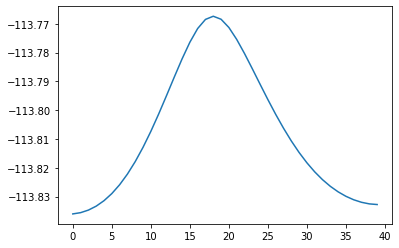

In [18]:
#Some operations before plotting
tmp1 = irc.iloc[22:].sort_values(by='energy')
tmp2 = irc.iloc[:22]
IRC = pd.concat([tmp1,tmp2])

#This is about the shape we should get from our NN on these coordinates
plt.plot(IRC.energy.values);

In [19]:
#Calculate energies using selected method and basis set (UHF/cc-pVDZ)
IRC['HF'] = IRC.drop(columns='energy').apply(HFenergy,axis=1)

ircFeats = IRC.drop(columns=['HF','energy']).apply(toDists,axis=1)
ircFeats['HF'] = IRC.HF

columns = []
#Same loops
for i in range(len(atoms)):
    for j in range(i+1,len(atoms)):  #Only atoms after ith (not counting it)
        columns.append(atoms[i]+atoms[j])
ircFeats.columns = columns + ['HF']

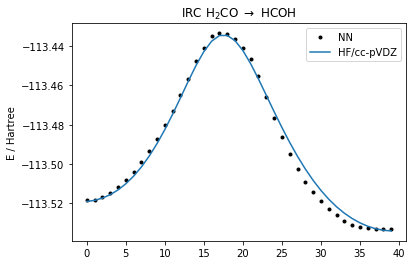

In [20]:
#Calculate NN-predicted energies
predictedIRC = E(ircFeats.drop(columns='HF'))

fig,ax = plt.subplots()
ax.plot(predictedIRC,'k.',label='NN')
ax.plot(ircFeats.HF.values,label='HF/cc-pVDZ')
ax.legend()

ax.set_title(r'IRC H$_2$CO $\rightarrow$ HCOH')
ax.set_ylabel('E / Hartree')
plt.show()

## Set up the dynamics.

First, compute the gradients. TensorFlow allows to easily calculate gradients of tensors with respect to other tensors, upon which the former depend. For this purpose we need to initialize a GradientTape and within it perform the operations that lead to the output y = y(x), then compute the gradient. 

We compute this by using `X=getInput(xyz)` to get the inputs and then `E = model(X)`. Finally the gradient is computed. This is all implemented in the function `Grad`.

In [21]:
#I better use TF for everything. 
#That is, calculate inputs as tensors and take gradients with respect to xyz
def getInput(xyz):
    """xyz: vector containing xyz coords of each atom [Ox, Oy, Oz, Cx, ...]
    pass xyz as tf.Variable(xyz)"""
    xyzM = tf.reshape(xyz,(3,1,4))
    xyzT = tf.transpose(xyzM,perm=[0,2,1])
    DistMatr = tf.sqrt(tf.reduce_sum(tf.square(xyzM-xyzT),axis=0))

    mask = np.zeros((4,4))
    mask[np.triu_indices(4,1)] = 1

    inps = 1./tf.boolean_mask(DistMatr,mask)
    return tf.reshape(inps,(-1,6))

def Grad(model,xyz):
    """Compute the gradients of E with respect to xyz coords"""
    xyz = tf.Variable(xyz) #Convert xyz np.array to tf.Variable
    with tf.GradientTape() as tape:  #Start recording operations
        X = getInput(xyz)   #Convert to inputs
        E = model(X)        #Calculate energies
    return tape.gradient(E,xyz).numpy()   #Return gradient of E wrt xyz

#Test
xyz = np.random.random(12)
Grad(model,xyz)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


array([ 5.40138210e+01, -3.42558459e-01, -2.72640277e-02, -5.36439985e+01,
        5.28605980e+01, -2.72244277e-01,  1.14078843e-01, -5.27024326e+01,
        1.73473329e+02, -2.11761292e+00,  2.29035998e-02, -1.71378620e+02])

In [22]:
class Trajectory:
    def __init__(self,X0,V0,b=0,Nsteps=1000,timeDelta=1e-17,Xdim=12,saveMolden=False,gradient=Grad):
        self.b = b
        self.Nsteps = Nsteps
        self.timeDelta = timeDelta
        self.Xdim = Xdim #Dimensionality of the space
        self.saveMolden = saveMolden
        self.gradient = gradient
        
        #Simulation initial conditions
        self.X0 = X0  #Initial coords (given in Ang)
        self.V0 = V0  #Initial velocities (given in Ang/s)
   
        #Initialize data array  (3D tensor: quantities x timestep x dimension )
        data=np.zeros((3,self.Nsteps,self.Xdim))
        self.data = data
    
    def getAccel(self,t):
        m = np.array([15.999,12.011,1.008,1.008])#Masses O,C,H1,H2
        m = np.repeat(m,3)*1.660540199e-27   #kg
        forces = -self.gradient(model,self.data[0,t])*431.75024  #kg*Ang/s**2
        accel = forces/m   #Ang/s^2
        return accel.reshape(1,-1)
        
    def run(self): #Using velocity verlet algorithm
        dt=self.timeDelta
        steps=self.Nsteps
        data=self.data
        
        #data: x,v,a. Start trajectory: fist point
        data[:2,0] = np.concatenate([self.X0, self.V0],axis=0) #Set initial position and velocities
        data[2,0] = self.getAccel(0)            #Compute initial acceleration
        
        for i in range(steps-1):
            data[0,i+1]=data[0,i]+data[1,i]*dt + 0.5*data[2,i]*dt*dt #update X
            data[2,i+1]=self.getAccel(i+1)                        #update acceleration
            tempV0_5=data[1,i]+0.5*data[2,i]*dt           #velocity at t+dt/2 (temporal)
            data[1,i+1]=tempV0_5 + 0.5*data[2,i+1]*dt     #velocity at t+dt
        self.data=data
        print("Trajectory completed!")
        
        if self.saveMolden:
            self.saveTrajectMOLDEN()
    
    def getData(self):
        return self.data
    
    def saveTrajectMOLDEN(self):
        """Pass as input a trayectory object"""
        coords = self.data[0]
        with open(self.saveMolden, "w") as f:
            for i,struct in enumerate(coords):
                print("4\nPoint {}\nO {:.8f} {:.8f} {:.8f}\nC {:.8f} {:.8f} {:.8f}\nH {:.8f} {:.8f} {:.8f}\nH {:.8f} {:.8f} {:.8f}".format(i,*struct),file=f)


### Algorithms are set up. Now only need to set initial conditions (position, velocity)
We want to simulate the reaction H + HCO$^+$. We'll be crashing the two fragments and look for what comes out.

In [23]:
#Define fragment one (HCO+) at the origin
xOCH = np.zeros(9)
xOCH[1] = -1.1  #O-C distance (along y axis)
xOCH[6] = 0.7   #Hx
xOCH[7] = 0.6   #Hy

#Define the H fragment position 
xH = np.zeros(3) #
xH[0] = -3.7   # Angstrom to the x axis
xH[1] = -5.6
X0 = np.concatenate([xOCH,xH]).reshape(1,-1)# + np.random.random(12)*0.04

#Now define velocities (only reactive trajectories occur from colissions)
unit = xH - xOCH[3:6]
unit = unit/np.linalg.norm(unit)   #Unit vector pointing in the direction HCO to H

v0 = 12000*1e10 #Relative velocity of the fragments (Ang/s)
vH = v0*unit

V0 = np.zeros(12).reshape(1,-1) 
V0[:,9:] = -vH.reshape(1,-1)  #Set velocity of the fragment

print(X0)
print(V0)

[[ 0.  -1.1  0.   0.   0.   0.   0.7  0.6  0.  -3.7 -5.6  0. ]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  6.61508719e+13  1.00120238e+14 -0.00000000e+00]]


9000 m/s is about 41 kJ/mol.

Moyano et al report relative kinetic energies in the range 13.1 to 26.3 kJ/mol, which correspond to 5100 - 7223 m/s

In [34]:
def HFgrad(model,row):
    """model is a dummy variable for compatibility
    Real gradient at HF/cc-pVDZ.
    This is expensive, use only for comparison
    Documentation: http://psicode.org/psi4manual/1.3.2/opt.html
    """
    psi4.set_memory('500 MB')

    #charge = +1, spin multipicity = 2
    h2o = psi4.geometry("""
    1 2
    O {} {} {}
    C {} {} {} 
    H {} {} {}
    H {} {} {}
    """.format(*row))
    
    psi4.set_options({'reference': 'uhf'})
    
    #Gradient calculated using UHF/cc-pVDZ
    try: 
        #Gradient is returned in Hartree/bohr -> convert to Hartree/ang
        return np.array(psi4.gradient('scf/cc-pvdz') ).flatten()  * 1.8897161 
    except:  #In case there's a convergence error or alike
        return 0.0
    
HFgrad(model,dataset.iloc[3,:-1].values)

array([-0.02116653,  0.01155505,  0.        ,  0.03730058, -0.02036241,
        0.        , -0.00254319,  0.014522  ,  0.        , -0.01359086,
       -0.00571464,  0.        ])

In [35]:
Grad(model,dataset.iloc[3,:-1].values)

array([ 0.41816652, -0.4013486 ,  0.10925035, -0.12606827,  0.        ,
        0.        ,  0.        ,  0.        , -0.14854462,  0.02821856,
       -0.0162704 ,  0.13659647])

They're pretty different

In [36]:
%%time
HFgrad(model,dataset.iloc[3,:-1].values)

CPU times: user 1.03 s, sys: 13.2 ms, total: 1.04 s
Wall time: 1.04 s


array([-0.02116653,  0.01155505,  0.        ,  0.03730058, -0.02036241,
        0.        , -0.00254319,  0.014522  ,  0.        , -0.01359086,
       -0.00571464,  0.        ])

In [37]:
%%time
Grad(model,dataset.iloc[3,:-1].values)

CPU times: user 13.9 ms, sys: 80 µs, total: 14 ms
Wall time: 13.3 ms


array([ 0.41816652, -0.4013486 ,  0.10925035, -0.12606827,  0.        ,
        0.        ,  0.        ,  0.        , -0.14854462,  0.02821856,
       -0.0162704 ,  0.13659647])

In [41]:
%%time

#Let's run a traj with full HF gradients for comparison
HFtraj = Trajectory(X0,V0,Nsteps=2000,timeDelta=1e-16,saveMolden='./HFtraj.txt',gradient=HFgrad)
HFtraj.run()

Trajectory completed!
CPU times: user 30min 49s, sys: 30.5 s, total: 31min 20s
Wall time: 33min 35s


In [42]:
%%time

#Now same traj with our NN PES
NNtraj = Trajectory(X0,V0,Nsteps=2000,timeDelta=1e-16,saveMolden='./NNtraj.txt',gradient=Grad)
NNtraj.run()

Trajectory completed!
CPU times: user 11.3 s, sys: 125 ms, total: 11.4 s
Wall time: 11.3 s


The trajectories have been stored to the file `HFtraj.txt` and `NNtraj`. It can be viewed with some visualization program such as [MOLDEN](http://cheminf.cmbi.ru.nl/molden/molden.html).

## Next step is to make the NN learn from these trajectories (as Moyano did). It will get better as more points of this trajectory are included in the training set.

In [91]:
a.getData()[0]

array([[-1.10000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -4.50000000e+00, -1.40000000e+00,  0.00000000e+00],
       [-1.10129429e+00, -6.04020659e-05,  1.55784420e-04, ...,
        -4.40918845e+00, -1.38320451e+00,  5.84105979e-03],
       [-1.10515042e+00, -2.48658158e-04,  6.27799963e-04, ...,
        -4.30822484e+00, -1.38669608e+00,  2.38518677e-02],
       ...,
       [-7.29603674e+00, -1.00747053e+01,  6.42473352e-01, ...,
        -4.47316371e+01,  3.57349573e+01,  1.65376684e+02],
       [-7.30828887e+00, -1.00788342e+01,  6.43052778e-01, ...,
        -4.48227055e+01,  3.57710698e+01,  1.65546187e+02],
       [-7.32060330e+00, -1.00829008e+01,  6.43632210e-01, ...,
        -4.49156026e+01,  3.58071831e+01,  1.65715690e+02]])